In [6]:
%cd eat_tensorflow2_in_30_days/

/home/jump/user/tzhou/TF/eat_tensorflow2_in_30_days


In [178]:
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers,models

dftrain_raw = pd.read_csv("./data/titanic/train.csv")
dftest_raw = pd.read_csv("./data/titanic/test.csv")
dfraw = pd.concat([dftrain_raw,dftest_raw])

In [179]:
dfraw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
174,650,1,3,"Stanley, Miss. Amy Zillah Elsie",female,23.0,0,0,CA. 2314,7.5500,NaN,S
175,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S
176,577,1,2,"Garside, Miss. Ethel",female,34.0,0,0,243880,13.0000,NaN,S
177,78,0,3,"Moutal, Mr. Rahamin Haim",male,NaN,0,0,374746,8.0500,NaN,S


In [181]:
feature_columns = []
# 数值列
for col in ['age','fare','parch','sibsp']:
    feature_columns.append(tf.feature_column.numeric_column(col, shape=(1,), default_value=None))

# 分桶列
age = tf.feature_column.numeric_column('age')
age_buckets = tf.feature_column.bucketized_column(age, 
             boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# 类别列
# 注意：所有的Catogorical Column类型最终都要通过indicator_column转换成Dense Column类型才能传入模型！！
sex = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='sex',vocabulary_list=["male", "female"]))
feature_columns.append(sex)

pclass = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='pclass',vocabulary_list=[1,2,3]))
feature_columns.append(pclass)

ticket = tf.feature_column.indicator_column(
     tf.feature_column.categorical_column_with_hash_bucket('ticket',3))
feature_columns.append(ticket)

embarked = tf.feature_column.indicator_column(
      tf.feature_column.categorical_column_with_vocabulary_list(
      key='embarked',vocabulary_list=['S','C','B']))
feature_columns.append(embarked)

# 嵌入列
cabin = tf.feature_column.embedding_column(
    tf.feature_column.categorical_column_with_hash_bucket('cabin',32),2)
feature_columns.append(cabin)

# 交叉列
pclass_cate = tf.feature_column.categorical_column_with_vocabulary_list(
          key='pclass',vocabulary_list=[1,2,3])

crossed_feature = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column([age_buckets, pclass_cate],hash_bucket_size=15))

feature_columns.append(crossed_feature)

# DEMO

In [13]:
import tensorflow as tf
print("tf.__version__ =", tf.__version__)

x = tf.constant(0.)
y = tf.constant(1.)

for _ in  range(50):
    x = x+y
    y = y/2
print(x.numpy())   

tf.__version__ = 2.2.0
2.0


# TF.KERAS

In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras


In [17]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000],  x_train_all[5000:]
y_valid, y_train = y_train_all[:5000],  y_train_all[5000:]

print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)
(10000, 28, 28) (10000,)


In [54]:
# 标准归一化  x = (x-u) / std
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)


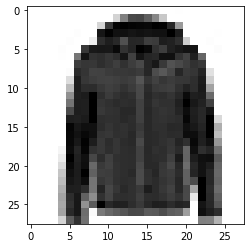

In [18]:
def show_single_image(img_arr):
    plt.imshow(img_arr, cmap='binary')
    plt.show()
    
show_single_image(x_train[0])

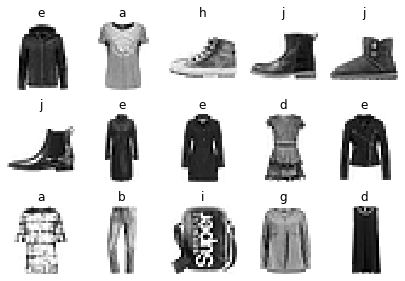

In [29]:
def show_image(n_rows, n_cols, x_data, y_data, class_names):
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols <= len(x_data)
    
    plt.figure(figsize=(n_cols*1.4, n_rows*1.6))
    for row in range(n_rows):
        for col in range(n_cols):
            index = n_cols * row + col
            plt.subplot(n_rows, n_cols, index+1)
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest")
            plt.axis('off')
            plt.title(class_names[y_data[index]])
    plt.show()

class_names = list('abcdefghijklmnopqrstuvwxyz')
show_image(3, 5, x_train, y_train, class_names)


In [72]:
# tf.keras.models.Sequential

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28],))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.AlphaDropout(0.5))
model.add(keras.layers.Dense(10, activation="softmax"))

'''
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28],),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
'''

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [73]:
model.layers

In [74]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 784)               3136      
_________________________________________________________________
dense_22 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_23 (Dense)             (None, 100)               30100     
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10)                1010      
Total params: 269,746
Trainable params: 268,178
Non-trainable params: 1,568
____________________________________________

In [75]:
n_params = 784*300+300 + 300 *100 + 100 + 100 *10 + 10
print('Total params:', n_params)

Total params: 266610


In [77]:
# history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))
history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2863 - accuracy: 0.8914 - val_loss: 0.4625 - val_accuracy: 0.8918
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2772 - accuracy: 0.8942 - val_loss: 0.4915 - val_accuracy: 0.8934
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2670 - accuracy: 0.8989 - val_loss: 0.5739 - val_accuracy: 0.8904
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2622 - accuracy: 0.9008 - val_loss: 0.5634 - val_accuracy: 0.8952
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2553 - accuracy: 0.9013 - val_loss: 0.5543 - val_accuracy: 0.8896
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2453 - accuracy: 0.9050 - val_loss: 0.6092 - val_accuracy: 0.8974
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2428 - accuracy: 0.9065 - val_loss: 0.6145 - val_accuracy:

In [46]:
print(type(history))
print(history.history)

<class 'tensorflow.python.keras.callbacks.History'>
{'loss': [2.502264976501465, 0.5803282260894775, 0.504670262336731, 0.46099889278411865, 0.42922186851501465, 0.41702088713645935, 0.39234796166419983, 0.3837701380252838, 0.3692149221897125, 0.36001676321029663], 'accuracy': [0.7215090990066528, 0.7922545671463013, 0.8187817931175232, 0.8345999717712402, 0.8471999764442444, 0.8520363569259644, 0.8594909310340881, 0.8637272715568542, 0.869418203830719, 0.8717636466026306], 'val_loss': [0.6341437697410583, 0.5731374025344849, 0.4905726909637451, 0.4607645571231842, 0.41478943824768066, 0.4168373942375183, 0.41393354535102844, 0.4069272577762604, 0.3895169794559479, 0.4069160521030426], 'val_accuracy': [0.7685999870300293, 0.8041999936103821, 0.840399980545044, 0.8417999744415283, 0.8587999939918518, 0.8550000190734863, 0.8557999730110168, 0.8525999784469604, 0.8727999925613403, 0.8641999959945679]}


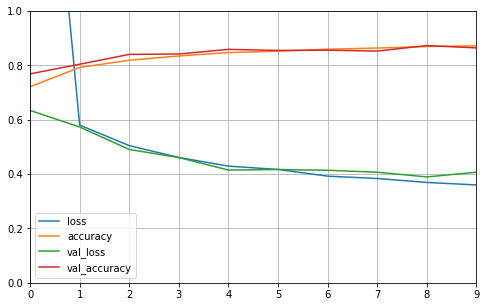

In [53]:
def plot_history(history):
    df = pd.DataFrame(history.history)
    df.plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.plot()

plot_history(history)

# keras.callbacks.{EarlyStopping, ModelCheckpoint, TensorBoard}


In [57]:
logdir = './tmp.callback'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, 'fashion_mnist_model.h5')
    
callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(filepath=output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(min_delta=1e-3, patience=5)
]

history = model.fit(x_train_scaled, y_train, epochs=100, 
                    validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

Epoch 1/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2001 - accuracy: 0.9241 - val_loss: 0.3457 - val_accuracy: 0.8822
Epoch 2/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1944 - accuracy: 0.9270 - val_loss: 0.3312 - val_accuracy: 0.8966
Epoch 3/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1833 - accuracy: 0.9304 - val_loss: 0.3790 - val_accuracy: 0.8852
Epoch 4/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1792 - accuracy: 0.9326 - val_loss: 0.3287 - val_accuracy: 0.8956
Epoch 5/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1730 - accuracy: 0.9353 - val_loss: 0.3567 - val_accuracy: 0.8960
Epoch 6/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1685 - accuracy: 0.9369 - val_loss: 0.3776 - val_accuracy: 0.8914
Epoch 7/100
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1622 - accuracy: 0.9381 - val_loss: 0.3931 - val_ac

In [60]:
!tensorboard --logdir=./tmp.callback --bind_all

TensorBoard 2.2.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


# Wide & Deep

- 稀疏特征
    - 离散值特征：One-hot表示
    - 叉乘：特征交叉[(计算机，人工智能), (Wide, Deep), ...]
        - 稀疏特征做叉乘后可以获取共现信息
        - 实现记忆效果
    - 优缺点
        - 优点：有效，广泛用于工业界
        - 缺点：需要人工设计；数量过多；可能过拟合，所有特征都叉乘，相当于记住每个样本
- 密集特征
    - 向量表达: embedding
    - Word2Vec工具
    - 优点：带有语义信息，向量间有相关性；兼容没有出现过的特征组合；更少人工参与
    - 缺点：过度泛化，推荐不怎么相关的产品


In [78]:
import tensorflow as tf
from tensorflow import keras


In [89]:
# 函数式API
inputs = keras.layers.Input(shape=(28,28))
flatten = keras.layers.Flatten(input_shape=(28, 28))(inputs)
hidden1 = keras.layers.Dense(30, activation='relu')(flatten)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate(inputs=[flatten, hidden2])
outputs = keras.layers.Dense(10, activation='softmax')(concat)

model = keras.models.Model(inputs=[inputs], outputs=outputs)
model.summary()


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), callbacks=callbacks)


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_15 (Flatten)            (None, 784)          0           input_11[0][0]                   
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 30)           23550       flatten_15[0][0]                 
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 30)           930         dense_51[0][0]                   
____________________________________________________________________________________________

In [114]:
# 子类API
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        """ 定义模型的层次 """
        self.flatten_layer = keras.layers.Flatten(input_shape=(28,28))
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(10, activation='softmax')
    
    def call(self, inputs):
        """ 前向传播 """
        flatten = self.flatten_layer(inputs)
        hidden1 = self.hidden1_layer(flatten)
        hidden2 = self.hidden2_layer(hidden1)
        concat = keras.layers.concatenate([flatten, hidden2])
        outputs = self.output_layer(concat)
        return outputs
    
model = WideDeepModel()
model.build(input_shape=(None, 28, 28))

model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)]
history = model.fit(x_train.astype('float32'), y_train, epochs=10, validation_data=(x_valid.astype('float32'), y_valid), callbacks=callbacks)


Model: "wide_deep_model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_34 (Flatten)         multiple                  0         
_________________________________________________________________
dense_105 (Dense)            multiple                  23550     
_________________________________________________________________
dense_106 (Dense)            multiple                  930       
_________________________________________________________________
dense_107 (Dense)            multiple                  8150      
Total params: 32,630
Trainable params: 32,630
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 16.9729 - accuracy: 0.7481 - val_loss: 14.9001 - val_accuracy: 0.7674
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 11.7670 - accuracy: 

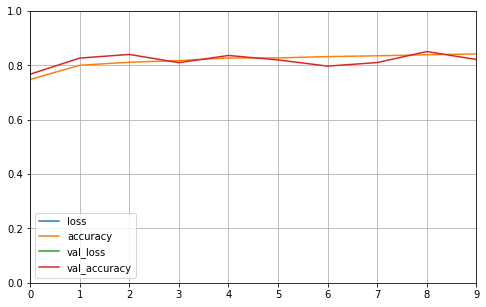

In [115]:
plot_history(history)

# TF基础API

In [116]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras


In [121]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])
print(t)
print(t[: , 1:])

print(t+10)
print(tf.square(t))
print(t @ tf.transpose(t))

print(t.numpy())
print(np.square(t))

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[2. 3.]
 [5. 6.]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[11. 12. 13.]
 [14. 15. 16.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[ 1.  4.  9.]
 [16. 25. 36.]], shape=(2, 3), dtype=float32)
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)
[[1. 2. 3.]
 [4. 5. 6.]]
[[ 1.  4.  9.]
 [16. 25. 36.]]


In [122]:
t = tf.constant(2.)
print(t.numpy())
print(t.shape)

2.0
()


In [127]:
t = tf.constant("abc广州")
print(t)
print(tf.strings.length(t))
print(tf.strings.length(t, unit="UTF8_CHAR"))
print(tf.strings.unicode_decode(t, "UTF8"))

t = tf.constant(["cafe", "coffee", "咖啡"])
print(tf.strings.length(t, unit="UTF8_CHAR"))
r = tf.strings.unicode_decode(t, "UTF8")  # RaggedTensor
print(r)

tf.Tensor(b'abc\xe5\xb9\xbf\xe5\xb7\x9e', shape=(), dtype=string)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor([   97    98    99 24191 24030], shape=(5,), dtype=int32)
tf.Tensor([4 6 2], shape=(3,), dtype=int32)
<tf.RaggedTensor [[99, 97, 102, 101], [99, 111, 102, 102, 101, 101], [21654, 21857]]>


In [129]:
# sparse tensor
s = tf.SparseTensor(indices=[[0,1], [1,0], [2,3]], # must be sorted
                    values=[1., 2., 3.],
                    dense_shape=[3, 4])
# s = tf.sparse.reorder(s)  # if not sorted
print(s)
print(tf.sparse.to_dense(s))

SparseTensor(indices=tf.Tensor(
[[0 1]
 [1 0]
 [2 3]], shape=(3, 2), dtype=int64), values=tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32), dense_shape=tf.Tensor([3 4], shape=(2,), dtype=int64))
tf.Tensor(
[[0. 1. 0. 0.]
 [2. 0. 0. 0.]
 [0. 0. 0. 3.]], shape=(3, 4), dtype=float32)


In [130]:
# Variable
t = tf.Variable([[0,1], [1,0], [2,3]])
print(t)

t[1].assign([1,2])
# dont use t[1] = [1,2], it would raise Error
print(t)

<tf.Variable 'Variable:0' shape=(3, 2) dtype=int32, numpy=
array([[0, 1],
       [1, 0],
       [2, 3]], dtype=int32)>
<tf.Variable 'Variable:0' shape=(3, 2) dtype=int32, numpy=
array([[0, 1],
       [1, 2],
       [2, 3]], dtype=int32)>


In [140]:
# customized  Loss
def customized_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y_true))


# customized layer
layer = keras.layers.Dense(100)
layer = keras.layers.Dense(100, input_shape=[None, 5])
# layer(tf.zeros([10, 5]))
# print(layer.variables)

class CustomizedDenseLayer(keras.layers.Layer):
    """ tf.keras.layers.Dense """
    def __init__(self, units, activation=None, **kwargs):
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    
    def build(self, input_shape):
        """ 构建所需要的的参数 """
        # x*w+b, input_shape=[None, a], w=[a,b], output_shape=[None, b]
        self.kernal = self.add_weight(name='kernal', 
                                     shape=[input_shape[1], self.units],
                                     initializer="uniform",
                                     trainable=True)
        self.bias = self.add_weight(name="bias",
                                   shape=(self.units),
                                   initializer="zeros",
                                   trainable=True)
        super(CustomizedDenseLayer, self).build(input_shape)
    
    def call(self, x):
        """ 前向传播 """
        return self.activation(x @ self.kernal + self.bias)

customized_softplus = keras.layers.Lambda(lambda x: tf.nn.softplus(x))
print(customized_softplus([[-5., -0., 5.], [-10., 0., 10.]]))

tf.Tensor(
[[6.7153489e-03 6.9314718e-01 5.0067153e+00]
 [4.5417706e-05 6.9314718e-01 1.0000046e+01]], shape=(2, 3), dtype=float32)


In [145]:
# tf.function and autograph
def scaled_elu(z, scale=1.0, alpha=1.0):
    # z >= 0 ? scale * z : scale * alpha * tf.nn.elu(z)
    is_positive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_positive, z, alpha*tf.nn.elu(z))

print(scaled_elu(tf.constant(-3.)))
print(scaled_elu(tf.constant([-3., -2.5])))


scaled_elu_tf = tf.function(scaled_elu)
print(scaled_elu_tf(tf.constant(-3.)))
print(scaled_elu_tf(tf.constant([-3., -2.5])))

%timeit _ = scaled_elu(tf.random.normal((1000, 1000)))
%timeit _ = scaled_elu_tf(tf.random.normal((1000, 1000)))

tf.Tensor(-0.95021296, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)
tf.Tensor(-0.95021296, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)
2.9 ms ± 24.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.57 ms ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [147]:
@tf.function
def converge_to_2(n_iters):
    total = tf.constant(0.)
    increment = tf.constant(1.)
    for _ in range(n_iters):
        total += increment
        increment /= 2.0
    return total

print(converge_to_2(20))

tf.Tensor(1.9999981, shape=(), dtype=float32)


In [149]:
def display_tf_code(func):
    code = tf.autograph.to_code(func)
    from IPython import display, Markdown
    display(Markdown('```python\n{}\n```'))
    
display_tf_code(scaled_elu)

ImportError: cannot import name 'Markdown'

In [152]:
var = tf.Variable(0.)   # Variable不能放在tf.function装饰的函数里面

@tf.function
def add_21():
    # cant here
    # var = tf.Variable(0.)
    return var.assign_add(21)

print(add_21())

tf.Tensor(21.0, shape=(), dtype=float32)


In [154]:
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name='x')])
def cube(z):
    return tf.pow(z, 3)

try:
    print(cube(tf.constant([1., 2., 3.])))
except ValueError as e:
    print(e)
    
print(cube(tf.constant([1, 2, 3])))


Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name='x'))
tf.Tensor([ 1  8 27], shape=(3,), dtype=int32)


# tf.data

In [155]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))
print(dataset)
for item in dataset:
    print(item)

<TensorSliceDataset shapes: (), types: tf.int64>
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


In [158]:
# 1. repeat epoch
# 2. get batch
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [159]:
# interleave
# case: 文件名dataset --> 具体数据集
dataset2 = dataset.interleave(
    lambda v: tf.data.Dataset.from_tensor_slices(v), # map_fn
    cycle_length=5, # cycle_length： 并行处理几个元素
    block_length=5, # block_length： 从上面变换的结果中取多少个元素出来
)

for item in dataset2:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype

In [162]:
x = np.array([[1,2], [3,4], [5,6]])
y = np.array(['cat', 'dog', 'fox'])
dataset3 = tf.data.Dataset.from_tensor_slices((x, y))
print(dataset3)

for item_x, item_y in dataset3:
    print(item_x.numpy(), item_y.numpy())

<TensorSliceDataset shapes: ((2,), ()), types: (tf.int64, tf.string)>
[1 2] b'cat'
[3 4] b'dog'
[5 6] b'fox'


In [165]:
# 1. filename --> dataset
# 2. read file --> dataset --> datasets --> merge
# 3. parse csv


# train_filenames = []
# valid_filenames = []
# test_filenames = []

# filename_dataset = tf.data.Dataset.list_files(train_filenames)
# dataset = filename_dataset.interleaver(
#     lambda filename: tf.data.TextLineDataset(filename).skip(1),
#     cycle_length = 5
# )
# for line in datasetset.tabke(15):
#     print(line.numpy())
    
    
def parse_csv_line(line, n_fields=9):
    defs = [tf.constant(np.nan)] * n_fields
    parsed_fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(parsed_fields[0:-1])
    y = tf.stack(parsed_fields[-1:])
    return x, y

parse_csv_line(b'-0.9,0.8,-0.1563,-0.9,0.8,-0.1563,-0.9,0.8,-0.1563', n_fields=9)


def csv_reader_dataset(filenames, n_readers=5, batch_size=32, n_parse_threads=5, shuffle_buffer_size=10000):
    dataset = df.data.Dataset.list_files(filenames)
    dataset = dataset.repeat()
    dataset = dataset.ionterleave(
        lambda filename: tf.data.TextLineDataset(filename).skip(1),
        cycle_length = n_readers
    )
    dataset.shuffle(shuffle_buffer_size=shuffle_buffer_size)
    dataset = dataset.map(parse_csv_line, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset

batch_size = 32
train_set = csv_reader_dataset(train_filenames, batch_size=batch_size)
valid_set = csv_reader_dataset(valid_filenames, batch_size=batch_size)
test_set = csv_reader_dataset(test_filenames, batch_size=batch_size)

model.fit(train_set, validation_data=valid_set, 
          steps_per_epoch=11160//batch_size, validation_steps=3870//batch_size,
         epochs=100, callbacks=callbacks)


(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([-0.9   ,  0.8   , -0.1563, -0.9   ,  0.8   , -0.1563, -0.9   ,
         0.8   ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.1563], dtype=float32)>)

# feature column & estimator

In [172]:
import tensorflow as tf
from tensorflow import keras

x = tf.data.Dataset.from_tensor_slices(["male", "female", "unknown"])

category_column = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", vocabulary_list=["male", "female", "unknown"])
#print(keras.layers.DenseFeatures(category_column)(x))
print(tf.compat.v1.feature_column.input_layer(x, [category_column])(x))

ValueError: Items of feature_columns must be a _DenseColumn. You can wrap a categorical column with an embedding_column or indicator_column. Given: VocabularyListCategoricalColumn(key='gender', vocabulary_list=('male', 'female', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [171]:
tf.compat.v1.feature_column.input_layer??

# my test

In [175]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class OneHotEncodingLayer(layers.experimental.preprocessing.PreprocessingLayer):
    def __init__(self, vocabulary=None, depth=None, minimum=None):
        super().__init__()
        self.vectorization = layers.experimental.preprocessing.TextVectorization(output_sequence_length=1)  

        if vocabulary:
            self.vectorization.set_vocabulary(vocabulary)
        self.depth = depth   
        self.minimum = minimum

    def adapt(self, data):
        self.vectorization.adapt(data)
        vocab = self.vectorization.get_vocabulary()
        self.depth = len(vocab)
        indices = [i[0] for i in self.vectorization([[v] for v in vocab]).numpy()]
        self.minimum = min(indices)

    def call(self, inputs):
        vectorized = self.vectorization.call(inputs)
        return tf.cast(vectorized, tf.float32)
        subtracted = tf.subtract(vectorized, tf.constant([self.minimum], dtype=tf.int64))
        encoded = tf.one_hot(subtracted, self.depth)
        return layers.Reshape((self.depth,))(encoded)

    def get_config(self):
        return {'vocabulary': self.vectorization.get_vocabulary(), 'depth': self.depth, 'minimum': self.minimum}

    
    
import pandas as pd
from tensorflow.keras import layers, models

colors_df = pd.DataFrame(data=[[5,'yellow'],[1,'red'],[2,'blue'],[3,'green'],[4,'blue'],[7,'purple']], columns=['id', 'color'])

categorical_input = layers.Input(shape=(1,), dtype=tf.string)
one_hot_layer = OneHotEncodingLayer()
one_hot_layer.adapt(colors_df['color'].values)
encoded = one_hot_layer(categorical_input)

numeric_input = layers.Input(shape=(1,), dtype=tf.float32)

concat = layers.concatenate([numeric_input, encoded])

model = models.Model(inputs=[numeric_input, categorical_input], outputs=[concat])
predicted = model.predict([colors_df['id'], colors_df['color']])
print(predicted)

[[5. 3.]
 [1. 4.]
 [2. 2.]
 [3. 6.]
 [4. 2.]
 [7. 5.]]


In [176]:
layers.DenseFeatures??

In [182]:
dir(sex)

['TensorSequenceLengthPair',
 '__abstractmethods__',
 '__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_asdict',
 '_fields',
 '_from_config',
 '_get_config',
 '_get_dense_tensor',
 '_get_sequence_dense_tensor',
 '_is_v2_column',
 '_make',
 '_parse_example_spec',
 '_replace',
 '_reset_config',
 '_source',
 '_transform_feature',
 '_transform_id_weight_pair',
 '_var_scope_name',
 '_variable_shape',
 'categorical_column',
 'count',
 'create_state',
 'from_confi

In [199]:
dir(sex.categorical_column)

['IdWeightPair',
 '__abstractmethods__',
 '__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_asdict',
 '_fields',
 '_from_config',
 '_get_config',
 '_get_sparse_tensors',
 '_is_v2_column',
 '_make',
 '_num_buckets',
 '_parse_example_spec',
 '_replace',
 '_reset_config',
 '_source',
 '_transform_feature',
 '_transform_input_tensor',
 '_var_scope_name',
 'count',
 'create_state',
 'default_value',
 'dtype',
 'from_config',
 'get_config',
 'get_sparse_tensors',

In [ ]:
class CategoryLayer(layers.Layer):
    def __init__(self):
        super().__init__()

    def adapt(self, voc):
        self.category_column = tf.feature_column.categorical_column_with_vocabulary_list("test", voc)

    def call(self, inputs):
        vectorized = self.category_column(inputs)
        return tf.cast(vectorized, tf.float32)


    def get_config(self):
        pass

    

In [208]:
from tensorflow.python.feature_column import dense_features
dense_features.DenseFeatures??

# my DeepFM

In [ ]:
from collections import defaultdict, Counter

import tensorflow as tf
from tensorflow import keras

# train data process
data = pd.DataFrame()
data[sparse_features] = df[sparse_features].copy()
data[multival_features] = df[multival_features].applymap(
    lambda x: [k for k, v in Counter(x.split(" ")).most_common(100)])
data[dense_features] = df[dense_features].copy()
target = [label_cols[2]]
data[target] = df[target].copy()

vocabulary_dict = {}
for feat_ in sparse_features:
    vocabulary_dict[feat_] = df[feat_].dropna().unique()

for feat_ in multival_features:
    vocabulary_dict[feat_] = df[feat_].dropna().unique()


# define feature column
feature_columns = defaultdict(list)

for feat_ in dense_features:
    col_ = tf.feature_column.numeric_column(feat_, shape=(1,))
    feature_columns['dense'].append(col_)

for feat_ in sparse_features:
    col_ = tf.feature_column.embedding_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feat_, vocabulary_list=vocabulary_dict[feat_]), 16)
    feature_columns["sparse"].append(col_)

for feat_ in multival_features:
    col_  = tf.feature_column.embedding_column(
        tf.feature_column.sequence_categorical_column_with_vocabulary_list(
            feat_, vocabulary_list=[]), 16)
    feature_columns["multival"].append(col_)

# show




In [226]:

def sell(percents, total=100.0):
    out_sum  = 0
    rest = total
    for i, p in enumerate(percents):
        p *= 0.01
        out = rest * p
        rest = rest - out
        print(i+1, round(p*100.0, 1), round(out, 2))
        out_sum += out
    print(out_sum)

sell(list([5]*20))

1 5.0 5.0
2 5.0 4.75
3 5.0 4.51
4 5.0 4.29
5 5.0 4.07
6 5.0 3.87
7 5.0 3.68
8 5.0 3.49
9 5.0 3.32
10 5.0 3.15
11 5.0 2.99
12 5.0 2.84
13 5.0 2.7
14 5.0 2.57
15 5.0 2.44
16 5.0 2.32
17 5.0 2.2
18 5.0 2.09
19 5.0 1.99
20 5.0 1.89
64.15140775914578


In [240]:
def get_item_page(n_items, pageNum, pageSize=10):
    pageNum = pageNum - 1
    n_items_each_page = pageSize
    itemPages = int(math.ceil(n_items / n_items_each_page))

    i_itemPage = pageNum % itemPages
    n_cycles = pageNum // itemPages
    assert(n_cycles * itemPages + i_itemPage == pageNum)
    return n_cycles, i_itemPage

get_item_page(100, 50)


(4, 9)